# Plot loss of training and validation duing epochs 

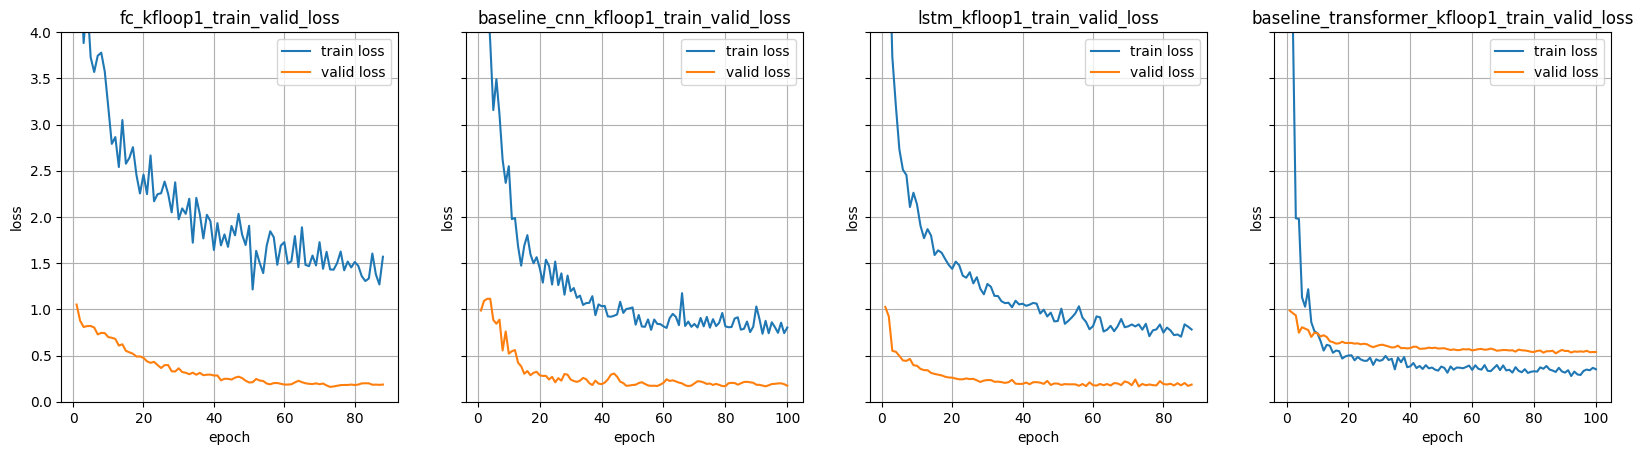

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pdb
loss_file_folder = "~/workspace/transfer_learning_for_droplanding/investigation_data_augmentation/train_valid_loss/"

def plot_loss(file_paths):
    if(not isinstance(file_paths, list)):
        file_paths=[file_paths]
        
    axes_num = len(file_paths)
    fig, axes=plt.subplots(1,axes_num,sharey=True);
    fig.set_figwidth(5*axes_num)
    
    for ax, file_path in zip(axes, file_paths):
        train_valid_loss_data = pd.read_csv(file_path)
        train_valid_loss_data = train_valid_loss_data.iloc[:]
        ax.plot(train_valid_loss_data['epoch'], train_valid_loss_data['total_train_loss'],label="train loss")
        ax.plot(train_valid_loss_data['epoch'], train_valid_loss_data['vali_loss'],label="valid loss")
        ax.set_xlabel("epoch");ax.set_ylabel("loss")
        ax.set_ylim([0,4])
        ax.set_title(os.path.basename(file_path)[:-4])
        ax.grid()
        ax.legend()
    plt.show()

loss_file_paths = [ os.path.join(loss_file_folder, "fc_kfloop1_" + "train_valid_loss.csv")]
loss_file_paths.append(os.path.join(loss_file_folder, "baseline_cnn_kfloop1_" + "train_valid_loss.csv"))
loss_file_paths.append(os.path.join(loss_file_folder, "lstm_kfloop1_" + "train_valid_loss.csv"))
loss_file_paths.append(os.path.join(loss_file_folder, "baseline_transformer_kfloop1_" + "train_valid_loss.csv"))

plot_loss(loss_file_paths)


In [2]:
#!/usr/bin/env python

import tensorflow as tf
# set hardware config
#tf.debugging.set_log_device_placement(True)

cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

# set gpu memory grouth automatically
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)

if(gpus!=[]):
    # set virtal gpu/ logical gpu, create four logical gpu from a physical gpu (gpus[0])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)
        ]
        )

logical_cpus = tf.config.experimental.list_logical_devices(device_type='CPU')
logical_gpus = tf.config.experimental.list_logical_devices(device_type='GPU')
print('physical cpus and gpus: ',cpus, gpus)
print('physical cpus number: ', len(cpus))
print('physical gpus number: ', len(gpus))
print('logical cpus and gpus: ',logical_cpus, logical_gpus)
print('logical cpgs number: ', len(logical_gpus))

print("tensorflow version:",tf.__version__)


import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_rawdata as pro_rd
import estimation_assessment.scores as es_as

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH, TRAIN_USED_TRIALS
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
from vicon_imu_data_process.dataset import *

from estimation_models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

from estimation_study import *
from estimation_assessment.visualization import *
#import pdb
import re


physical cpus and gpus:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] []
physical cpus number:  1
physical gpus number:  0
logical cpus and gpus:  [LogicalDevice(name='/device:CPU:0', device_type='CPU')] []
logical cpgs number:  0
tensorflow version: 2.5.0
tensorflow version: 2.5.0
tensorflow version: 2.5.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')] []


## Model investigation

In [2]:
import develop 

investigation_variables={
     "sensor_configurations": {'FSTWC': ['FOOT','SHANK','THIGH','WAIST', 'CHEST']},
     "syn_features_labels": [False, True],
     #'estimated_variables': [['KNEE_MOMENT_X'], ['GRF_Z']],  # KFM, KAM, GRF
     'estimated_variables': [['GRF_Z']],
     #"landing_manners": ['single_leg_R', 'double_legs'],
     "landing_manners": ['double_legs'],
 
     #"lstm_units": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
     #"lstm_units": [15, 20, 25, 30, 35]
     #"lstm_units": [5, 10]
     "lstm_units": [35],
     'target_leg': 'R'
}


#combination_investigation_results = develop.integrative_investigation(investigation_variables,'double_GRF_R_syn_5sensor_35',fold_number=1)
#print(combination_investigation_results)



physical cpus and gpus:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] []
physical cpus number:  1
physical cpgs number:  0
logical cpus and gpus:  [LogicalDevice(name='/device:CPU:0', device_type='CPU')] []
logical cpgs number:  0
tensorflow version: 2.5.0


# Training results analysis


## load training data folder

In [3]:

# 45 lstm units with all sensor configs
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-27/204501/testing_result_folders.txt"

# several sensor config and various lstm units
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-27/143322/testing_result_folders.txt"

# all sensor config and 35 lstm units
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-30/all_sensor_list/testing_result_folders.txt"
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-06/150524/testing_result_folders.txt"
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-06/153846/off_on_synchronizationtesting_result_folders.txt"
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-09/204902/off_on_synchronizationtesting_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-12/112206/double_KFM_R_syn_5sensor_35testing_result_folders.txt"
print(combination_investigation_results)

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-12/112206/double_KFM_R_syn_5sensor_35testing_result_folders.txt


In [4]:
investigation_config_results =  get_investigation_training_testing_folders(combination_investigation_results)
print(investigation_config_results)

  Sensor configurations  LSTM units  syn_features_labels landing_manners  \
0                 FSTWC          35                False     double_legs   
1                 FSTWC          35                False     double_legs   
2                 FSTWC          35                 True     double_legs   
3                 FSTWC          35                 True     double_legs   

  estimated_variables                                    testing_folders  \
0               [KFM]  /media/sun/DATA/Drop_landing_workspace/suntao/...   
1               [KFM]  /media/sun/DATA/Drop_landing_workspace/suntao/...   
2               [KFM]  /media/sun/DATA/Drop_landing_workspace/suntao/...   
3               [KFM]  /media/sun/DATA/Drop_landing_workspace/suntao/...   

                                    training_folders  
0  /media/sun/DATA/Drop_landing_workspace/suntao/...  
1  /media/sun/DATA/Drop_landing_workspace/suntao/...  
2  /media/sun/DATA/Drop_landing_workspace/suntao/...  
3  /media/sun/DATA

## Plot history

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-05-12/training_111613/train_process/my_history
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Max train and validtion MAE: 0.2907 and 0.3684


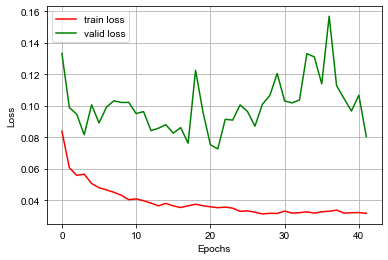

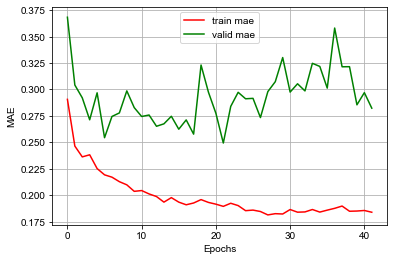

In [5]:
training_folder = investigation_config_results['training_folders'][0]
history_file = training_folder + '/train_process/my_history'
print(history_file)

#history_file = os.path.join(RESULTS_PATH, "training_testing_results/2022-04-14/training_220632/train_process/my_history")
history = json.load(open(history_file, 'r'))
plot_history(history)

## plot statistical results

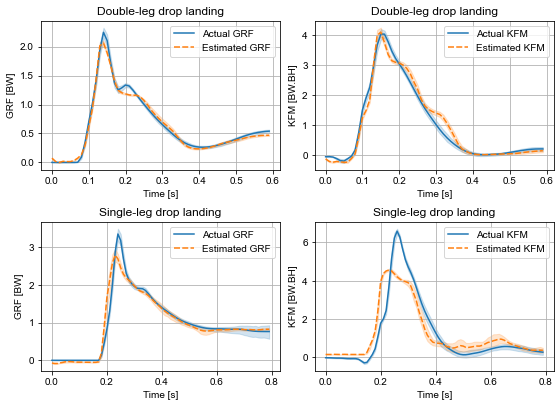

In [54]:

combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/testing_result_folders.txt"
display_configs = { 'test_ids': ['test_153345','test_091548','test_122609','test_104906'],
                    'ylabel': ['GRF [BW]', 'KFM [BW.BH]','GRF [BW]', 'KFM [BW.BH]'],
                    'subplot_titles': [
                                        'Double-leg drop landing',
                                        'Double-leg drop landing',
                                        'Single-leg drop landing',
                                        'Single-leg drop landing'
                                      ],
                    'legends': [
                            ['Actual GRF', 'Estimated GRF'],
                            ['Actual KFM', 'Estimated KFM'],
                            ['Actual GRF', 'Estimated GRF'],
                            ['Actual KFM', 'Estimated KFM']
                              ]
                    }
a, b = plot_statistic_actual_estimation_curves(combination_investigation_results,
                                        verbose=1,
                                        display_configs=display_configs)

**Figure 1. Ensemble curves for GRF and KFM in double-leg and single-leg drop landing. The actual and predicted GRFs and KFMs are shown as the solid and dashed line.**

### Plot estimation value of a trial

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/10_03/training_112407
DO NOT synchronize features and labels: False
subject: P_10_dongxuan and trial: 37
Estimation metrics: (r2, mae, rmse, r_rmse)  (0.786, 0.372, 0.253, 0.106)


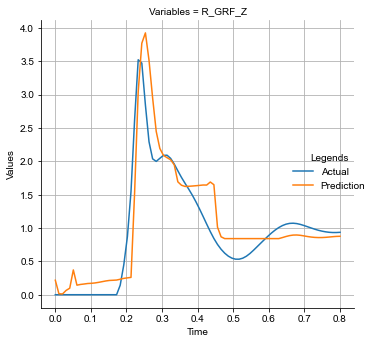

In [32]:
# -----------Plot results
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/00_16/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/10_03/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/testing_result_folders.txt"

training_folder =  get_investigation_training_testing_folders(combination_investigation_results,'training_002433')
print(training_folder)

subject_id_name=None
trial = '37'
pd_predictions, pd_labels, testing_folder, metrics = test_model_on_unseen_trial(training_folder, 
                                                                                subject_id_name=subject_id_name,
                                                                                trial=trial)
plot_actual_estimation_curves(pd_labels, pd_predictions, 
                              testing_folder = testing_folder,
                              #fig_title = subject_id_name + '_' + trial, metrics='r2: ' + str(metrics[0]),
                              verbose=1)
    

***The results is not right, checking syn_features_labels***

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/00_16/test_003743/test_1


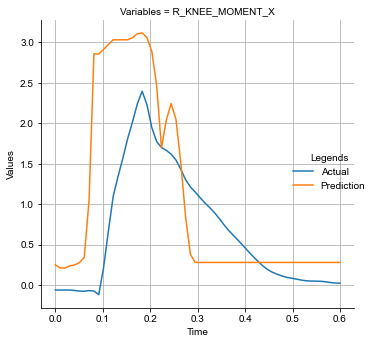

R_KNEE_MOMENT_X: scores (r2, rmse, mae, r_rmse): -0.604 0.937 0.632 0.373


,metrics,fields,scores
0,r2,R_KNEE_MOMENT_X,-0.604
1,rmse,R_KNEE_MOMENT_X,0.937
2,mae,R_KNEE_MOMENT_X,0.632
3,r_rmse,R_KNEE_MOMENT_X,0.373


In [7]:
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/001/testing_result_folders.txt"

testing_folder =  get_investigation_training_testing_folders(combination_investigation_results,'test_003743')+'/test_1'
print(testing_folder)
[pd_labels, pd_predictions] = get_testing_results(testing_folder)
plot_prediction(pd_labels,pd_predictions,testing_folder,verbose=1)
get_evaluation_metrics(pd_labels,pd_predictions,verbose=1)

In [116]:
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/r2_metrics.csv"
r2_metrics = get_investigation_metrics(combination_investigation_results)
group_metrics = r2_metrics.groupby(['estimated_variables','landing_manners','syn_features_labels'])
statistic_metrics = group_metrics.describe().loc[:,'scores']
statistic_metrics.loc[:,('mean','std')].T

estimated_variables       [GRF]                              [KFM]            \
landing_manners     double_legs           single_leg_R double_legs             
syn_features_labels       False     True         False       False     True    
mean                   0.762954  0.897655     0.743040    0.849463  0.885136   
std                    0.140769  0.077500     0.215937    0.100128  0.117189   

estimated_variables               
landing_manners     single_leg_R  
syn_features_labels        False  
mean                    0.809584  
std                     0.139781

In [3]:
from estimation_assessment.visualization import *
#combination_investigation_results = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/combination_investigation_results/2022-04-09/200611/testing_result_folders.txt"
#combination_investigation_results = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/combination_investigation_results/2022-04-12/170711/testing_result_folders.txt"
#combination_investigation_results = os.path.join(RESULTS_PATH,"combination_investigation_results/2022-04-12/153004/testing_result_folders.txt")
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/testing_result_folders.txt"
investigation_config_results =  get_investigation_training_testing_folders(combination_investigation_results,'test_123113')
print(investigation_config_results)
#plot_combination_investigation_results(combination_investigation_results)
#training_folder = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/models_parameters_results/2022-04-08/training_200647"
#check_model_test(training_folder)

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/12_09/test_123113


### Investigation of the influence of \bt{sensor configurations} on GRF estimation performance

In [55]:
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/valid_results/complete_config/r2_metrics.csv"
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-05-13/001/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/metrics.csv"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/10_14/testing_result_folders.txt"
fig_path = plot_sensor_config_investigation_results(combination_investigation_results,
                                                        landing_manner = 'double_legs',
                                                        estimated_variable = '[KFM]',
                                                        syn_features_label = 'both',
                                                        title=' estimation in double-leg drop landing', drop_value=0.6)


DROP R2 cases below :0.6
specified estimated variable is not right, it should be: {'[GRF]'}


SystemExit: 

/home/sun/.pyenv/versions/DataVisualization/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/r2_metrics.csv"

DROP R2 cases below :0.5


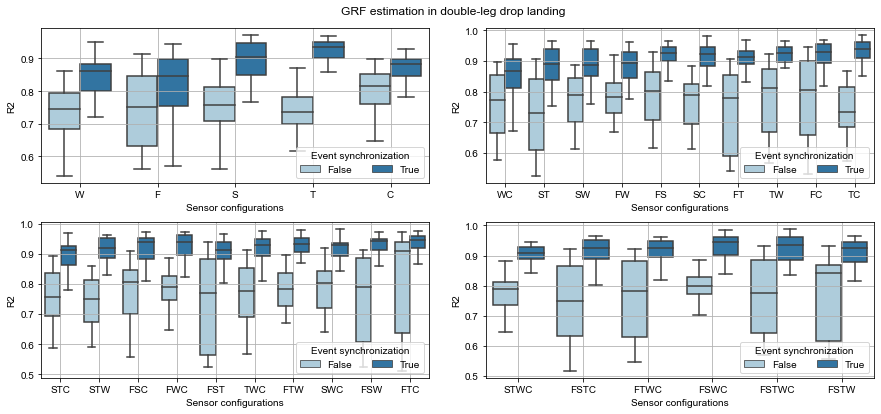

In [7]:
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-05-13/001/metrics.csv"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/r2_metrics.csv"
fig_path = plot_sensor_config_investigation_results(combination_investigation_results,
                                                        landing_manner = 'double_legs',
                                                        estimated_variable = '[GRF]',
                                                        syn_features_label = 'both',
                                                        title=' estimation in double-leg drop landing',drop_value=0.6)

### Investigation of the influence of \bt{model size} on GRF estimation performance

## exit machine and save environment

In [ ]:
os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node -save -name suntao_env")

DROP R2 cases below :0.6
All LSTM units are used


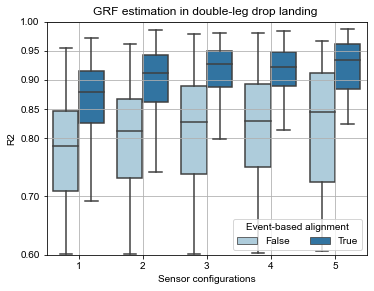

In [16]:

combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/latest_train/metrics.csv"
r1 = plot_overall_sensor_config_investigation_results(combination_investigation_results,
                                    landing_manner='double_legs',
                                    estimated_variable='GRF',
                                    syn_features_label='both',
                                    title=' estimation in double-leg drop landing',
                                    LSTM_unit=35, drop_value=0.6)


## 读取测试数据


In [1]:
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-08-03/23_35/testing_result_folders.txt"

metrics = get_list_investigation_metrics(combination_investigation_results)

NameError: name 'get_list_investigation_metrics' is not defined